## Подключение вспомогательных библиотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

## Подключение библиотеки `gmdhpy`

In [2]:
sys.path.insert(1, "C:/Users/Mi/Documents/Diploma/GMDH/build/Release")
sys.path.insert(1, "/home/mikhail-xnor/Projects/GMDH/build")
sys.path.insert(1, "/Users/mikhail-x/Projects/GMDH/build")
import gmdhpy as gm

In [17]:
print("Состав библиотеки")
dir(gm)

Состав библиотеки


['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

## Код для линейной регрессии, реализация combi на python, функции метрик

In [4]:
def data_preparation(x, lags, validate_size, test_size=0):
    x_data = list()
    y_data = list()
    for i in range(len(x) - lags):
        x_data.append(list(x[i:i+lags]))
        y_data.append(x[i+lags])
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validate_size, shuffle=False)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=False)
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_val, y_val

def print_polynom(polynom, coeffs):
    best_polynom_str = "y ="
    for i in range(len(polynom)):
        if coeffs[i] > 0:
            if i > 0:
                best_polynom_str += " + "
            else:
                best_polynom_str += " "
        else:
            best_polynom_str += " - "
        best_polynom_str += str(round(abs(coeffs[i]), 4))
        if i != len(coeffs) - 1:
            best_polynom_str += "*x" + str(polynom[i] + 1)
    print(best_polynom_str)
    
def regression(x, lags, validate_size):
    x_train, y_train, x_val, y_val = data_preparation(x, lags, validate_size)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    coeffs = list(lr.coef_)
    coeffs.append(lr.intercept_)
    coeffs = [round(coeff, 6) for coeff in coeffs]
    y_pred = lr.predict(x_val)
    error = round(mean_squared_error(y_pred, y_val), 6)
    print_polynom(range(lags + 1), coeffs)
    return y_pred

def regression_combi(x, lags, validate_size, test_size):
    x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(x, lags, validate_size, test_size)
    lr = LinearRegression(n_jobs=-1)
    last_error = 100000000000000
    best_coeffs = []
    best_polynom = []
    for level in range(1, x_train.shape[1] + 1):
        errors = []
        for comb in combinations(range(x_train.shape[1]), level):
            lr.fit(x_train[:, comb], y_train)
            coeffs = list(lr.coef_)
            coeffs.append(lr.intercept_)
            coeffs = [round(coeff, 6) for coeff in coeffs]
            y_pred = lr.predict(x_test[:, comb])
            error = round(mean_squared_error(y_pred, y_test), 6)
            comb = list(comb)
            comb.append(lags)
            errors.append((error, coeffs, comb))
        errors.sort()
        #print(errors[0])
        if last_error >= errors[0][0]:
            last_error = errors[0][0]
            best_coeffs = errors[0][1]
            best_polynom = errors[0][2]
        else:
            break
    print_polynom(best_polynom, best_coeffs)
    y_pred = lr.fit(x_train[:, best_polynom[:-1]], y_train).predict(x_val[:, best_polynom[:-1]])
    return y_pred

def print_metrics(y_test, y_pred):
    print("\nMETRICS")
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")
    
def ts_stat(y_real, y_pred):
    y_real_diff = np.diff(y_real)
    y_pred_diff = np.diff(y_pred)
    print("right:", ((y_real_diff * y_pred_diff > 0)).sum())
    print("wrong:", ((y_real_diff * y_pred_diff < 0)).sum())
    print("zero:", ((y_real_diff * y_pred_diff == 0)).sum())

## Загрузка и предобработка датасета

In [5]:
datasets = ['numbers', 'sber', 'notebooks']
chosen_dataset = datasets[1]

In [6]:
if chosen_dataset == datasets[0]:
    data = np.array([i + np.random.rand() for i in range(100)])
    lags = 5
    test_size = 0.33
    validate_size = 0.2
    is_ts = True

    mat, vec = gm.time_series_transformation(data, lags)
    splited_data = gm.split_data(mat, vec, validate_size, False, 0)
    
elif chosen_dataset == datasets[1]:
    data = pd.read_csv("Sberbank.csv")['close'][-3000:]
    lags = 15
    test_size = 0.3
    validate_size = 0.2
    is_ts = True

    mat, vec = gm.time_series_transformation(data, lags)
    splited_data = gm.split_data(mat, vec, validate_size, False, 0)

elif chosen_dataset == datasets[2]:
    data = pd.read_csv("laptop_price.csv")
    #data = data[data.columns[data.dtypes != object]].drop(['laptop_ID', 'Memory2_GB'], axis=1)
    data = data.drop(['laptop_ID', 'Memory2_GB'], axis=1)
    data = data.drop(data[data['Ram_GB'] == 64].index)
    test_size = 0.2
    validate_size = 0.2
    is_ts = False
    category_cols = data.columns[data.dtypes == object]
    #for col in category_cols:
    #    print(f'{col}: {data[col].unique().size}')
    data = pd.get_dummies(data=data.drop(['Product', 'Cpu_series', 'Gpu_series'], axis=1), 
                          columns=category_cols.drop(['Product', 'Cpu_series', 'Gpu_series']))
    splited_data = gm.split_data(data.drop(['Price_euros'], axis=1), data['Price_euros'])
    scaler = MinMaxScaler().fit(splited_data.x_train)
    splited_data.x_train = scaler.transform(splited_data.x_train)
    splited_data.x_test = scaler.transform(splited_data.x_test)

else: print("unknown option:", chosen_dataset)

## Обучение моделей

In [7]:
# argument only for time series datasets
#   set -1 to make predictions for all series based on real data in each step
#   set positive integer value to predict some lags without watching real test data after each step
lags_to_predict = 5

In [11]:
%%time
print("COMBI model\n")
combi = gm.Combi()
combi.fit(splited_data.x_train, splited_data.y_train, 
          criterion=gm.SequentialCriterion(gm.CriterionType.regularity, gm.CriterionType.stability, solver=gm.Solver.accurate), 
          test_size=test_size, p_average=0, n_jobs=-10, verbose=1, limit=0)
print("\n" + combi.get_best_polynomial())
if is_ts and lags_to_predict > 0:
    y_pred_combi = combi.predict(splited_data.x_test[0], lags_to_predict) 
    print_metrics(splited_data.y_test[:lags_to_predict], y_pred_combi)
else:
    y_pred_combi = combi.predict(splited_data.x_test)
    print_metrics(splited_data.y_test, y_pred_combi)

<timed exec>:3: Warning: 
Warning! The input number of n_jobs is incorrect!
The default value is used (n_jobs = 1)!

<timed exec>:3: Warning: 
Warning! The input number of p_average is incorrect!
The default value is used (p_average = 1)!



COMBI model

LEVEL 1  [=========================] 100% :00s] (15 combinations) error=9594.187737                                 
LEVEL 2  [=========================] 100% :00s] (105 combinations) error=9475.315027                                
LEVEL 3  [=========================] 100% :00s] (455 combinations) error=9346.634503                                
LEVEL 4  [=========================] 100% :00s] (1365 combinations) error=9317.465985                               
LEVEL 5  [=========================] 100% :00s] (3003 combinations) error=9275.349956                               
LEVEL 6  [=========================] 100% :00s] (5005 combinations) error=9263.716963                               
LEVEL 7  [=========================] 100% :01s] (6435 combinations) error=9261.192399                               
LEVEL 8  [=========================] 100% :01s] (6435 combinations) error=9262.992104                               

y = - 0.0132*x1 + 0.0288*x3 - 0.0067*x7 - 0.0256*x

In [8]:
%%time
print("MULTI model\n")
multi = gm.Multi()
multi.fit(splited_data.x_train, splited_data.y_train, 
          criterion=gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 
          k_best=3, test_size=test_size, p_average=1, n_jobs=-1, verbose=1, limit=0)
print("\n" + multi.get_best_polynomial())
if is_ts and lags_to_predict > 0:
    y_pred_multi = multi.predict(splited_data.x_test[0], lags_to_predict) 
    print_metrics(splited_data.y_test[:lags_to_predict], y_pred_multi)
else:
    y_pred_multi = multi.predict(splited_data.x_test)
    print_metrics(splited_data.y_test, y_pred_multi)

MULTI model

LEVEL 1  [=========================] 100% :00s] (15 combinations) error=8126.690212
LEVEL 2  [=========================] 100% :00s] (39 combinations) error=8011.604115
LEVEL 3  [=========================] 100% :00s] (36 combinations) error=7883.970821
LEVEL 4  [=========================] 100% :00s] (33 combinations) error=7856.10513
LEVEL 5  [=========================] 100% :00s] (30 combinations) error=7814.468967
LEVEL 6  [=========================] 100% :00s] (27 combinations) error=7802.857803
LEVEL 7  [=========================] 100% :00s] (24 combinations) error=7800.384971
LEVEL 8  [=========================] 100% :00s] (21 combinations) error=7802.653047

y = - 0.0132*x1 + 0.0288*x3 - 0.0067*x7 - 0.0256*x8 + 0.0465*x11 - 0.0042*x12 + 0.9718*x15 + 0.638

METRICS
R^2: -1.5070127370214066
MSE: 99.75798785815536
MAE: 7.9646787477151495

CPU times: user 1.47 s, sys: 9.03 ms, total: 1.48 s
Wall time: 379 ms


In [13]:
%%time
print("MIA model\n")
mia = gm.Mia()
mia.fit(splited_data.x_train, splited_data.y_train, 
        criterion=gm.Criterion(gm.CriterionType.sym_regularity, gm.Solver.accurate), 
        k_best=5, polynomial_type=gm.PolynomialType.linear, test_size=test_size,
        p_average=1, n_jobs=-1, verbose=1, limit=0);
print("\n" + mia.get_best_polynomial())
if is_ts and lags_to_predict > 0:
    y_pred_mia = mia.predict(splited_data.x_test[0], lags_to_predict) 
    print_metrics(splited_data.y_test[:lags_to_predict], y_pred_mia)
else:
    y_pred_mia = mia.predict(splited_data.x_test)
    print_metrics(splited_data.y_test, y_pred_mia)

MIA model

LEVEL 1  [=========================] 100% :00s] (105 combinations) error=9546.953061                                
LEVEL 2  [=========================] 100% :00s] (10 combinations) error=9512.496278                                 
LEVEL 3  [=========================] 100% :00s] (10 combinations) error=9500.732489                                 
LEVEL 4  [=========================] 100% :00s] (10 combinations) error=9499.463388                                 
LEVEL 5  [=========================] 100% :00s] (10 combinations) error=9499.084928                                 
LEVEL 6  [=========================] 100% :00s] (10 combinations) error=9499.423846                                 

f1_1 = 0.0271*x11 + 0.9704*x15 + 0.6361
f1_2 = 0.0249*x12 + 0.9725*x15 + 0.6582
f1_3 = 0.0111*x10 + 0.9863*x15 + 0.6719
f1_4 = 0.0095*x9 + 0.9879*x15 + 0.6706
f1_5 = 0.0071*x4 + 0.9904*x15 + 0.6568

f2_1 = 1.4665*f1_1 - 0.4665*f1_3 + 0.001
f2_2 = 1.3156*f1_1 - 0.3156*f1_4 + 0.0008
f2_3

In [14]:
%%time
print("RIA model\n")
ria = gm.Ria()
ria.fit(splited_data.x_train, splited_data.y_train, 
        criterion=gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate),
        k_best=3, polynomial_type=gm.PolynomialType.linear, test_size=test_size,
        p_average=1, n_jobs=-1, verbose=1, limit=1e-4)
print("\n" + ria.get_best_polynomial())
if is_ts and lags_to_predict > 0:
    y_pred_ria = ria.predict(splited_data.x_test[0], lags_to_predict) 
    print_metrics(splited_data.y_test[:lags_to_predict], y_pred_ria)
else:
    y_pred_ria = ria.predict(splited_data.x_test)
    print_metrics(splited_data.y_test, y_pred_ria)

RIA model

LEVEL 1  [=========================] 100% :00s] (105 combinations) error=8011.604115                                
LEVEL 2  [=========================] 100% :00s] (45 combinations) error=7976.489875                                 
LEVEL 3  [=========================] 100% :00s] (45 combinations) error=7922.104604                                 
LEVEL 4  [=========================] 100% :00s] (45 combinations) error=7905.738583                                 
LEVEL 5  [=========================] 100% :00s] (45 combinations) error=7889.911812                                 
LEVEL 6  [=========================] 100% :00s] (45 combinations) error=7886.828621                                 
LEVEL 7  [=========================] 100% :00s] (45 combinations) error=7881.841415                                 
LEVEL 8  [=========================] 100% :00s] (45 combinations) error=7880.565561                                 
LEVEL 9  [=========================] 100% :00s] (45 c

In [15]:
%%time
print("COMBI on python model\n")
y_pred_lr_combi = regression_combi(data, lags, validate_size, test_size)
print_metrics(splited_data.y_test, y_pred_lr_combi)

COMBI on python model

y = 0.0074*x1 - 0.0055*x2 - 0.0086*x4 + 0.0141*x9 + 0.9925*x10 + 0.0131

METRICS
R^2: 0.9994748809277221
MSE: 0.32659381457936076
MAE: 0.36143711131149997

CPU times: total: 28.8 s
Wall time: 29.1 s


In [ ]:
%%time
print("LR python model\n")
y_pred_lr = regression(data, lags, validate_size)
print_metrics(splited_data.y_test, y_pred_lr)

## Сравнение результатов

In [15]:
lags_to_predict = 10
test_n_show = splited_data.y_test.shape[0]
show_train = False

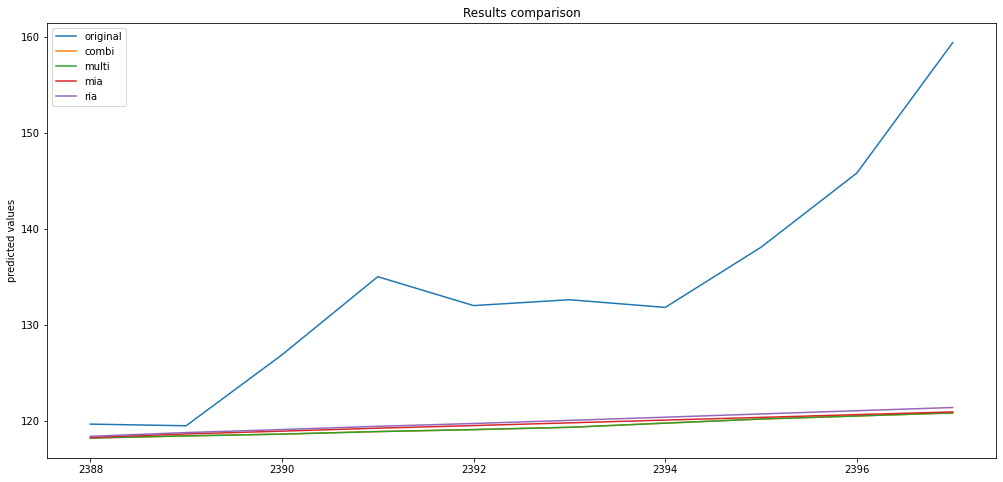

In [16]:
if lags_to_predict > 0:
    y_pred_combi = combi.predict(splited_data.x_test[0], lags_to_predict)
    y_pred_multi = multi.predict(splited_data.x_test[0], lags_to_predict)
    y_pred_mia = mia.predict(splited_data.x_test[0], lags_to_predict)
    y_pred_ria = ria.predict(splited_data.x_test[0], lags_to_predict)
    test_n_show = lags_to_predict
else:
    y_pred_combi = combi.predict(splited_data.x_test[:test_n_show])
    y_pred_multi = multi.predict(splited_data.x_test[:test_n_show])
    y_pred_mia = mia.predict(splited_data.x_test[:test_n_show])
    y_pred_ria = ria.predict(splited_data.x_test[:test_n_show])

start_test = splited_data.y_train.shape[0]
end_test = start_test + test_n_show
plt.figure(figsize=(17, 8))
if show_train:
    sns.lineplot(x=np.arange(0, end_test), y=list(splited_data.y_train) + list(splited_data.y_test[:test_n_show]), label='original');
else:
    sns.lineplot(x=np.arange(start_test, end_test), y=splited_data.y_test[:test_n_show], label='original');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_combi[:test_n_show], label='combi');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_multi[:test_n_show], label='multi');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_mia[:test_n_show], label='mia');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_ria[:test_n_show], label='ria');
#sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_lr_combi[:test_n], label='regr_combi');
#sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_lr[:test_n], label='regr');
plt.title("Results comparison")
plt.ylabel("predicted values")
plt.show();

In [17]:
print("Оценка верных предсказаний направления изменения цен акции\n")
print("COMBI")
ts_stat(splited_data.y_test[:test_n_show], y_pred_combi)
print("\nMULTI")
ts_stat(splited_data.y_test[:test_n_show], y_pred_multi)
print("\nMIA")
ts_stat(splited_data.y_test[:test_n_show], y_pred_mia)
print("\nRIA")
ts_stat(splited_data.y_test[:test_n_show], y_pred_ria)

Оценка верных предсказаний направления изменения цен акции

COMBI
right: 6
wrong: 3
zero: 0

MULTI
right: 6
wrong: 3
zero: 0

MIA
right: 6
wrong: 3
zero: 0

RIA
right: 6
wrong: 3
zero: 0


## Пример обработки некорректных данных

In [11]:
try:
    y_pred_multi = multi.predict(np.delete(splited_data.x_test, -1, 1))
except gm.GmdhException as err:
    print(err)
try:
    multi.save("./")
except gm.GmdhException as err:
    print(err)
try:
    multi.load("multi.txt")
except gm.GmdhException as err:
    print(err)
try:
    multi.load("mia1.txt")
except gm.GmdhException as err:
    print(err)
try:
    multi.load("multi1.txt")
except gm.GmdhException as err:
    print(err)

Input data number of cols is not match number of cols of fitted data!
Input model file path is not exist!
Input model file path is not exist!
Input file for model is MIA, but used model is MULTI!
Input model file is corrupted!


## Пример сохранения и загрузки модели из файла

In [19]:
y_pred_mia = mia.predict(splited_data.x_test)
mia.save("mia1.txt")
new_mia = gm.Mia()
new_mia.load("mia1.txt")
y_pred_new_mia = new_mia.predict(splited_data.x_test)

if (np.round(y_pred_mia, 4) == np.round(y_pred_new_mia, 4)).sum() == splited_data.x_test.shape[0]:
    print("Предсказания до сохранения и после загрузки совпали")
else:
    print("ОШИБКА! Предсказания до сохранения и после загрузки отличаются")

Предсказания до сохранения и после загрузки совпали
